In [1]:
import sys
sys.path.append('../')

import numpy as np
import pygme

%load_ext autoreload
%autoreload 2

from pygme import GuidedModeExp, Circle, PhotCryst, Lattice
from pygme.guided_modes_new import guided_modes
import matplotlib.pyplot as plt
from itertools import zip_longest

## W1 waveguide supercell

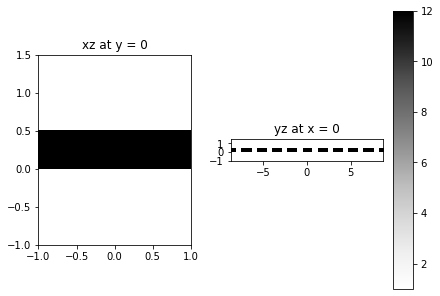

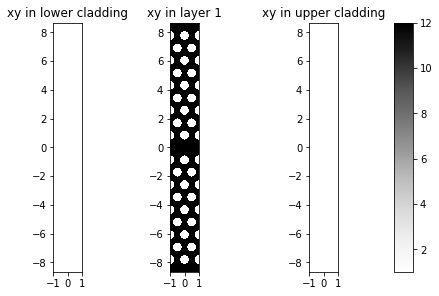

In [2]:
# Number of PhC periods in vertical direction
Ny = 10
# Radius of circle holes
ra = 0.3
# Initialize a lattice
lattice = Lattice([1., 0], [0, Ny*np.sqrt(3)/2])
# Initialize a PhC (by default with eps = 1 in upper and lower cladding, we set upper one to 5)
phc = PhotCryst(lattice)
# Add a layer to the PhC with thickness 1 and background permittivity 10
phc.add_layer(d=0.5, eps_b=12.)
# Add a shape to this layer 
for ih in range(Ny):
    if ih != Ny//2:
        circ = Circle(x_cent=(ih%2)*0.5, y_cent = (-Ny//2 + ih)*np.sqrt(3)/2, r=ra)
        phc.layers[-1].add_shape(circ)
# Plot an overview picture
phc.plot_overview(cladding='True', Ny=500)

## Define and run the guided mode expansion

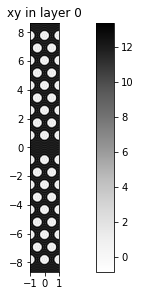

In [3]:
gme = GuidedModeExp(phc, gmax=3)
gme.plot_overview_ft(Ny=500)

In [4]:
path = phc.lattice.bz_path(['G', np.array([np.pi, 0])], [50])

In [7]:
gme.run(kpoints=path.kpoints, gmode_inds=[0], N_g_array = 500, verbose=False)

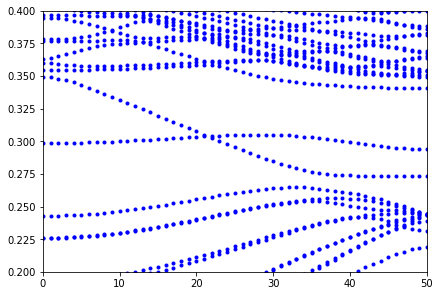

In [8]:
# And plot the results!
fig, ax = plt.subplots(1, constrained_layout=True)
plt.plot(gme.freqs, '.b')
ax.set_ylim([0.2, 0.4])
ax.set_xlim([0, gme.freqs.shape[0]-1])
plt.show()

In [9]:
print(gme.freqs.shape)

(51, 50)


In [10]:
xcs = [(ih%2)*0.5 for ih in range(Ny)]
ycs = [(-Ny//2 + ih)*np.sqrt(3)/2 for ih in range(Ny)]

In [11]:
# Define a waveguide with "moved" holes
def gme_w1(xm, ym):
    phc = PhotCryst(lattice)
    phc.add_layer(d=0.5, eps_b=12.)
    for ih in range(Ny):
        if ih != Ny//2:
            xc = xcs[ih]
            yc = ycs[ih]
            if np.abs(-Ny//2 + ih) < xm.size + 0.5:
                xc += xm[np.abs(-Ny//2 + ih)-1]
                yc += ym[np.abs(-Ny//2 + ih)-1]*np.sign((-Ny//2 + ih))
            circ = Circle(x_cent=xc, y_cent=yc, r=ra)
            phc.layers[-1].add_shape(circ)
    gme = GuidedModeExp(phc, gmax=3)
    return gme

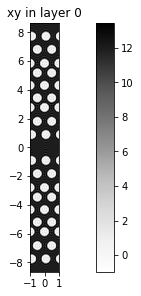

In [13]:
gme_test = gme_w1(np.array([0.1, 0, 0]), np.array([0.05, 0.1, 0.2]))
gme_test.plot_overview_ft(Ny=500)

In [15]:
print([shape.x_cent for shape in gme_test.phc.layers[0].shapes])
print([shape.y_cent/np.sqrt(3)*2 for shape in gme_test.phc.layers[0].shapes])

[0.0, 0.5, 0.0, 0.5, 0.1, 0.1, 0.5, 0.0, 0.5]
[-5.0, -4.0, -3.230940107675851, -2.1154700538379254, -1.0577350269189627, 1.0577350269189627, 2.1154700538379254, 3.230940107675851, 4.0]


In [16]:
import autograd.numpy as npa
from autograd import grad
pygme.set_backend('autograd')

In [26]:
# Define an objective function
# It's somewhat random, but let's try to make the dispersion in the end of the guided band as flat as possible
def of_w1(params):
    xm = params[0:3]
    ym = params[3:6]
    # Initialize the GME
    gme = gme_w1(xm, ym)

    # Run the GME
    gme.run(kpoints=path.kpoints, gmode_inds=[0], N_g_array = 500, verbose=False)
    # These is not exactly the guided band but should be correct for the region right around the band edge at X
    freqs_wg = gme.freqs[:, Ny]

    return npa.sqrt(npa.var(freqs_wg[-20:]))

print(of_w1(np.zeros((6,))))

0.002777876684296912


In [27]:
# Let's first test the gradient
from pygme.utils import grad_num
grad_test = grad(of_w1)

print('Autograd gradient:  ', grad_test(np.zeros((6,))))
print('Numerical gradient: ', grad_num(of_w1, np.zeros((6,))))

Autograd gradient:   [ 3.46944695e-18  5.63785130e-18 -1.08420217e-19 -1.13076769e-03
  1.05338335e-02  3.91651295e-04]
Numerical gradient:  [-5.89805982e-10 -3.42174206e-09 -2.47198095e-09 -1.13077377e-03
  1.05338329e-02  3.91649981e-04]


In [28]:
from pygme.optimizers import adam_optimize

In [29]:
p_start = np.zeros((6,))

In [32]:
# Run the optimization
(p_opt, ofs) = adam_optimize(of_w1, p_start, grad_test, step_size = 1e-2, Nsteps = 10, 
                             options = {'direction': 'min', 'disp': ['of', 'params']})

At iteration 0 :
Objective value is:   0.002777876684296912
Parameters are:       [ 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000]
At iteration 1 :
Objective value is:   0.0026507499189839753
Parameters are:       [-0.0000 -0.0000  0.0000  0.0100 -0.0100 -0.0100]
At iteration 2 :
Objective value is:   0.002509803375784128
Parameters are:       [-0.0000 -0.0000  0.0000  0.0197 -0.0200 -0.0200]
At iteration 3 :
Objective value is:   0.002353083764891872
Parameters are:       [ 0.0002 -0.0010  0.0009  0.0293 -0.0300 -0.0300]
At iteration 4 :
Objective value is:   0.0021722297837349263
Parameters are:       [ 0.0060 -0.0068  0.0067  0.0389 -0.0401 -0.0401]
At iteration 5 :
Objective value is:   0.0019578567666006614
Parameters are:       [ 0.0118 -0.0127  0.0129  0.0486 -0.0501 -0.0502]
At iteration 6 :
Objective value is:   0.0016957598114226689
Parameters are:       [ 0.0186 -0.0195  0.0201  0.0583 -0.0602 -0.0603]
At iteration 7 :
Objective value is:   0.0013732669526795892
Parameters 

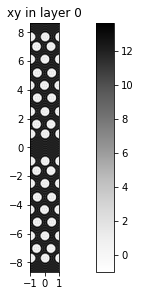

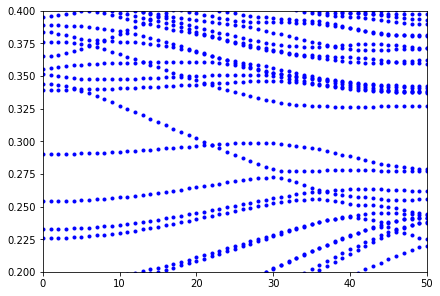

In [34]:
gme_test = gme_w1(np.array(p_opt[0:3]), np.array(p_opt[3:6]))
gme_test.plot_overview_ft(Ny=500)
gme_test.run(kpoints=path.kpoints, gmode_inds=[0], N_g_array = 500, verbose=False)

fig, ax = plt.subplots(1, constrained_layout=True)
plt.plot(gme_test.freqs, '.b')
ax.set_ylim([0.2, 0.4])
ax.set_xlim([0, gme.freqs.shape[0]-1])
plt.show()

## Well I'll be damned, it worked! 
Although, this might not be exactly what we want, because the guided band now looks mixed with the valence bands.
As usual, the problem is with writing a good objective function and constraining your parameters well.
But apart from that, **I'll be damned, it worked!**